<a href="https://colab.research.google.com/github/shauryashah/ML-Lab-Assignments/blob/master/Assignment%205/ML5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install keras-rl2
!pip install gym[box2d]

     |████████████████████████████████| 52 kB 700 kB/s 
     |████████████████████████████████| 448 kB 26.7 MB/s 


In [2]:
%%bash

# install required system dependencies
apt-get install -y xvfb x11-utils

# install required python dependencies (might need to install additional gym extras depending)
pip install gym[box2d]==0.17.* pyvirtualdisplay==0.2.* PyOpenGL==3.1.* PyOpenGL-accelerate==3.1.*

Reading package lists...
Building dependency tree...
Reading state information...
The following additional packages will be installed:
  libxxf86dga1
Suggested packages:
  mesa-utils
The following NEW packages will be installed:
  libxxf86dga1 x11-utils xvfb
0 upgraded, 3 newly installed, 0 to remove and 37 not upgraded.
Need to get 994 kB of archives.
After this operation, 2,981 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libxxf86dga1 amd64 2:1.1.4-1 [13.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 x11-utils amd64 7.7+3build1 [196 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.9 [784 kB]
Fetched 994 kB in 1s (1,591 kB/s)
Selecting previously unselected package libxxf86dga1:amd64.
(Reading database ... 155222 files and directories currently installed.)
Preparing to unpack .../libxxf86dga1_2%3a1.1.4-1_amd64.deb ...
Unpacking libxxf86dga1:amd64 (2:1.1.4-1) ...
S

In [14]:
import pyvirtualdisplay


_display = pyvirtualdisplay.Display(visible=False,  # use False with Xvfb
                                    size=(1400, 900))
_ = _display.start()

In [15]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Reshape, Conv2D, Dense, Flatten, BatchNormalization, Dropout, MaxPooling2D
from tensorflow.keras.optimizers import Adam, SGD

from rl.agents import DQNAgent
from rl.policy import EpsGreedyQPolicy
from rl.memory import SequentialMemory

In [16]:
def plot_average_reward(reward_list, ave_reward_list):
  plt.plot(np.arange(len(reward_list)), reward_list, label='Episode Reward')
  plt.plot(100*(np.arange(len(ave_reward_list)) + 1), ave_reward_list, label='Average Reward')
  plt.legend(loc='upper left')
  plt.xlabel('Episodes')
  plt.title('Average Reward vs Episodes')   
  plt.show()

In [6]:
env = gym.make('MountainCar-v0')
env.reset()

array([-0.49038668,  0.        ])

In [7]:
print('State space: ', env.observation_space)
print('Action space: ', env.action_space)
print(env.observation_space.low)
print(env.observation_space.high)

State space:  Box(-1.2000000476837158, 0.6000000238418579, (2,), float32)
Action space:  Discrete(3)
[-1.2  -0.07]
[0.6  0.07]


Mountain Car (Reinforcement Learning)

In [8]:
%%time

learning = 0.1
discount = 0.95
epsilon = 0.5
min_eps = 0.0
episodes = 5000
epsilon_decay = (epsilon-min_eps)/episodes
reward_list = []
ave_reward_list = []
win_count = 0
cumu_timesteps = 0

discrete_obs_size = [20]*len(env.observation_space.high)
discrete_obs_window = (env.observation_space.high-env.observation_space.low)/discrete_obs_size
q_table = np.random.uniform(low=-2, high=0, size=(discrete_obs_size+[env.action_space.n]))

def get_discrete_state(state):
  discrete_state = (state-env.observation_space.low)/discrete_obs_window
  return tuple(discrete_state.astype(np.int))


for episode in range(episodes):
  discrete_state = get_discrete_state(env.reset())
  tot_reward = 0
  done=False
  while not done:

    cumu_timesteps+=1
    if np.random.random() > epsilon:
      action = np.argmax(q_table[discrete_state])
    else:
      action = np.random.randint(0, env.action_space.n)

    new_state, reward, done, _ = env.step(action)
    new_discrete_state = get_discrete_state(new_state)
    if not done:
      max_future_q = np.max(q_table[new_discrete_state])
      current_q = q_table[discrete_state + (action,)]
      new_q = (1-learning)*current_q + learning*(reward + discount*max_future_q)
      q_table[discrete_state + (action,)] = new_q
    
    elif new_state[0] >= env.goal_position:
      win_count+=1
      q_table[discrete_state + (action,)] = 0
    
    tot_reward+=reward
    discrete_state = new_discrete_state
  
  if epsilon > min_eps:
    epsilon-=epsilon_decay
  reward_list.append(tot_reward)
        
  if (episode+1) % 100 == 0:
      ave_reward = np.mean(reward_list[episode-99:])
      ave_reward_list.append(ave_reward)
      
  if (episode+1) % 500 == 0:    
      print('Episode {} Average Reward: {}'.format(episode+1, ave_reward))
env.close()


Episode 500 Average Reward: -200.0
Episode 1000 Average Reward: -200.0
Episode 1500 Average Reward: -197.19
Episode 2000 Average Reward: -197.84
Episode 2500 Average Reward: -196.77
Episode 3000 Average Reward: -192.31
Episode 3500 Average Reward: -189.47
Episode 4000 Average Reward: -180.81
Episode 4500 Average Reward: -174.06
Episode 5000 Average Reward: -166.87
CPU times: user 1min 25s, sys: 3.62 s, total: 1min 28s
Wall time: 1min 24s


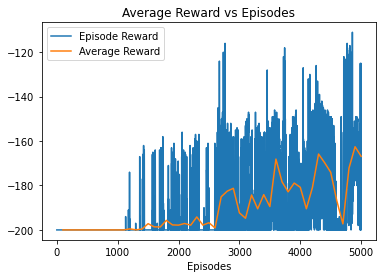

In [9]:
plot_average_reward(reward_list, ave_reward_list)

Mountain Car(Deep Q Learning)

In [10]:
nb_actions = 3
nb_states = 2

In [11]:
model = Sequential()
model.add(Flatten(input_shape=(1,) + env.observation_space.shape))
model.add(Dense(128, activation='relu'))
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(3, activation="relu"))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 2)                 0         
                                                                 
 dense (Dense)               (None, 128)               384       
                                                                 
 dense_1 (Dense)             (None, 512)               66048     
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 67,971
Trainable params: 67,971
Non-trainable params: 0
_________________________________________________________________


In [12]:
policy = EpsGreedyQPolicy()
memory = SequentialMemory(limit=5000, window_length=1)
agent = DQNAgent(model=model, memory=memory, policy=policy, nb_actions=nb_actions,
                 nb_steps_warmup=500, target_model_update=1e-2)
agent.compile(Adam(lr=1e-3), metrics=['mse'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [13]:
agent.fit(env, nb_steps=50000, visualize=False, verbose=1, nb_max_episode_steps=1000)

Training for 50000 steps ...
Interval 1 (0 steps performed)
  115/10000 [..............................] - ETA: 8s - reward: -1.0000

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


10000/10000 [==============================] - 99s 10ms/step - reward: -1.0000
50 episodes - episode_reward: -200.000 [-200.000, -200.000] - loss: 0.500 - mse: 0.333 - mean_q: 0.000

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 102s 10ms/step - reward: -1.0000
50 episodes - episode_reward: -200.000 [-200.000, -200.000] - loss: 0.500 - mse: 0.333 - mean_q: 0.000

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 103s 10ms/step - reward: -1.0000
50 episodes - episode_reward: -200.000 [-200.000, -200.000] - loss: 0.500 - mse: 0.333 - mean_q: 0.000

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 103s 10ms/step - reward: -1.0000
50 episodes - episode_reward: -200.000 [-200.000, -200.000] - loss: 0.500 - mse: 0.333 - mean_q: 0.000

Interval 5 (40000 steps performed)
10000/10000 [==============================] - 103s 10ms/step - reward: -1.0000
done, took 510.955 seconds


In [ ]:
agent.save_weights('dqn_{}_weights.h5f'.format('MountainCar'), overwrite=True)

In [ ]:
agent.test(env, nb_episodes=10, nb_max_episode_steps=1000, visualize=False)

Testing for 10 episodes ...
Episode 1: reward: -200.000, steps: 200
Episode 2: reward: -200.000, steps: 200
Episode 3: reward: -200.000, steps: 200
Episode 4: reward: -200.000, steps: 200
Episode 5: reward: -200.000, steps: 200
Episode 6: reward: -200.000, steps: 200
Episode 7: reward: -200.000, steps: 200
Episode 8: reward: -200.000, steps: 200
Episode 9: reward: -200.000, steps: 200
Episode 10: reward: -200.000, steps: 200


Roulette (Reinforcement Learning)

In [ ]:
env = gym.make('Roulette-v0')
env.reset()

0

In [ ]:
print('State space: ', env.observation_space)
print('Action space: ', env.action_space)

State space:  Discrete(1)
Action space:  Discrete(38)


In [ ]:
%%time

learning = 0.1
discount = 0.95
epsilon = 0.5
min_eps = 0.0
episodes = 50000
epsilon_decay = (epsilon-min_eps)/episodes
reward_list = []
ave_reward_list = []

q_table = np.random.randn(env.observation_space.n, env.action_space.n)
for episode in range(episodes):
  state = env.reset()
  tot_reward = 0
  done=False
  while not done:
    if np.random.random() > epsilon:
      action = np.argmax(q_table[state,:])
    else:
      action = np.random.randint(0, env.action_space.n)

    new_state, reward, done, _ = env.step(action)
    max_future_q = np.max(q_table[new_state, :])
    current_q = q_table[state, action]
    new_q = (1-learning)*current_q + learning*(reward + discount*max_future_q)
    q_table[state, action] = new_q
    tot_reward+=reward
    state = new_state
  
  if epsilon > min_eps:
    epsilon-=epsilon_decay
  reward_list.append(tot_reward)
        
  if (episode+1) % 100 == 0:
      ave_reward = np.mean(reward_list[episode-99:])
      ave_reward_list.append(ave_reward)
      #reward_list = []
      
  if (episode+1) % 500 == 0:    
      print('Episode {} Average Reward: {}'.format(episode+1, ave_reward))
env.close()


Episode 500 Average Reward: -0.16
Episode 1000 Average Reward: 0.71
Episode 1500 Average Reward: -1.26
Episode 2000 Average Reward: 0.58
Episode 2500 Average Reward: -1.55
Episode 3000 Average Reward: -0.85
Episode 3500 Average Reward: -1.8
Episode 4000 Average Reward: -0.86
Episode 4500 Average Reward: -1.8
Episode 5000 Average Reward: 0.99
Episode 5500 Average Reward: -1.12
Episode 6000 Average Reward: -0.91
Episode 6500 Average Reward: -1.53
Episode 7000 Average Reward: -0.84
Episode 7500 Average Reward: -0.01
Episode 8000 Average Reward: -1.06
Episode 8500 Average Reward: -0.78
Episode 9000 Average Reward: -1.07
Episode 9500 Average Reward: 0.88
Episode 10000 Average Reward: -1.45
Episode 10500 Average Reward: -0.43
Episode 11000 Average Reward: -1.28
Episode 11500 Average Reward: -0.69
Episode 12000 Average Reward: -1.82
Episode 12500 Average Reward: -0.66
Episode 13000 Average Reward: 0.16
Episode 13500 Average Reward: -0.39
Episode 14000 Average Reward: -0.56
Episode 14500 Avera

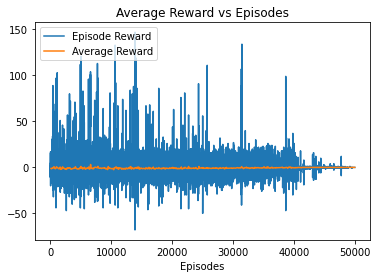

In [ ]:
plot_average_reward(reward_list, ave_reward_list)

In [ ]:
env = gym.make('Roulette-v0')
print(env.observation_space)
print(env.observation_space.shape)
print(env.action_space)
print(env.action_space.shape)

Discrete(1)
()
Discrete(38)
()


In [ ]:
print('State space: ', env.observation_space)
print('Action space: ', env.action_space)

State space:  Box(0, 255, (96, 96, 3), uint8)
Action space:  Box(-1.0, 1.0, (3,), float32)


In [ ]:
nb_actions = 38
nb_states = 1

In [ ]:
model = Sequential()
model.add(Dense(128, input_dim=nb_states))
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(38, activation="relu"))
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_36 (Dense)            (None, 128)               256       
                                                                 
 dense_37 (Dense)            (None, 256)               33024     
                                                                 
 dropout_11 (Dropout)        (None, 256)               0         
                                                                 
 dense_38 (Dense)            (None, 38)                9766      
                                                                 
Total params: 43,046
Trainable params: 43,046
Non-trainable params: 0
_________________________________________________________________


In [ ]:
policy = EpsGreedyQPolicy()
memory = SequentialMemory(limit=5000, window_length=1)
agent = DQNAgent(model=model, memory=memory, policy=policy, nb_actions=nb_actions,
                 nb_steps_warmup=500, target_model_update=1e-2)
agent.compile(Adam(lr=1e-3), metrics=['mse'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
agent.fit(env, nb_steps=50000, visualize=False, verbose=1, nb_max_episode_steps=1000)

Training for 50000 steps ...
Interval 1 (0 steps performed)


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


10000/10000 [==============================] - 116s 12ms/step - reward: 0.0016
113 episodes - episode_reward: -0.027 [-98.000, 128.000] - loss: 16.004 - mse: 0.842 - mean_q: 0.000

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 116s 12ms/step - reward: 0.0697
114 episodes - episode_reward: 6.325 [-96.000, 136.000] - loss: 17.740 - mse: 0.934 - mean_q: 0.000

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 114s 11ms/step - reward: -0.0204
108 episodes - episode_reward: -1.833 [-92.000, 152.000] - loss: 16.013 - mse: 0.843 - mean_q: 0.000

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 113s 11ms/step - reward: 0.1126
111 episodes - episode_reward: 9.207 [-94.000, 249.000] - loss: 17.532 - mse: 0.923 - mean_q: 0.000

Interval 5 (40000 steps performed)
10000/10000 [==============================] - 110s 11ms/step - reward: -0.0289
done, took 568.864 seconds


In [ ]:
agent.test(env, nb_episodes=10, nb_max_episode_steps=1000, visualize=False)

Testing for 10 episodes ...
Episode 1: reward: -26.000, steps: 100
Episode 2: reward: 11.000, steps: 100
Episode 3: reward: -63.000, steps: 100
Episode 4: reward: -26.000, steps: 100
Episode 5: reward: 11.000, steps: 100
Episode 6: reward: 11.000, steps: 100
Episode 7: reward: -26.000, steps: 100
Episode 8: reward: -63.000, steps: 100
Episode 9: reward: -26.000, steps: 100
Episode 10: reward: 85.000, steps: 100


In [ ]:
env = gym.make('CarRacing-v0')
print(env.observation_space)
print(env.observation_space.shape)
print(env.action_space)
print(env.action_space.shape)

Box(0, 255, (96, 96, 3), uint8)
(96, 96, 3)
Box(-1.0, 1.0, (3,), float32)
(3,)


/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [17]:
class CarRacingDiscrit:

    def __init__(self):
        self.env = gym.make('CarRacing-v0')
        self.action_space = 10*10*10
        self.observation_space = 96*96*3

    def step(self, action):
        v1 = int(     action        ) % 10
        v2 = int( int(action) / 10  ) % 10
        v3 = int( int(action) / 100 ) % 10
        v1 = ( v1 - 5 ) / 5
        v2 = ( v2     ) / 10
        v3 = ( v3     ) / 10
        state, reward, done, info = self.env.step([v1, v2, v3])
        return state, reward, done, info
 
    def seed(self, s):
        return env.seed(s)

    def reset(self):
        return self.env.reset()
    def render(self):
        return self.env.render()

    def close(self):
        return self.env.close()

In [18]:
env = CarRacingDiscrit()
#env.seed(123)
nb_actions = 10*10*10
print(env.observation_space)
print(env.action_space)

27648
1000


/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [19]:
model = Sequential()
model.add(Reshape((96, 96, 3), input_shape=(1, 96, 96, 3)))
model.add(BatchNormalization())
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(192, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(1000, activation="relu"))
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 96, 96, 3)         0         
                                                                 
 batch_normalization (BatchN  (None, 96, 96, 3)        12        
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 47, 47, 32)       0         
 )                                                               
                                                                 
 batch_normalization_1 (Batc  (None, 47, 47, 32)       128       
 hNormalization)                                

In [20]:
policy = EpsGreedyQPolicy()
memory = SequentialMemory(limit=5000, window_length=1)
agent = DQNAgent(model=model, memory=memory, policy=policy, nb_actions=nb_actions,
                 nb_steps_warmup=500, target_model_update=1e-2)
agent.compile(Adam(lr=1e-3), metrics=['mse'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [21]:
agent.fit(env, nb_steps=10000, visualize=False, verbose=1, nb_max_episode_steps=1000)

Training for 10000 steps ...
Track generation: 1080..1354 -> 274-tiles track
Interval 1 (0 steps performed)


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


10000/10000 [==============================] - 6076s 608ms/step - reward: -0.0528
done, took 6077.922 seconds


In [22]:
agent.save_weights('dql_{}_weights.h5f'.format('CarRacing'), overwrite=True)

In [23]:
# Finally, evaluate our algorithm for 5 episodes.
agent.test(env, nb_episodes=10, nb_max_episode_steps=1000, visualize=False)

Testing for 10 episodes ...
Track generation: 1309..1643 -> 334-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1165..1461 -> 296-tiles track
Episode 1: reward: -28.814, steps: 1000
Track generation: 1022..1291 -> 269-tiles track
Episode 2: reward: -51.493, steps: 1000
Track generation: 1042..1306 -> 264-tiles track
Episode 3: reward: -20.152, steps: 1000
Track generation: 1062..1334 -> 272-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1157..1456 -> 299-tiles track
Episode 4: reward: -42.953, steps: 1000
Track generation: 1323..1658 -> 335-tiles track
Episode 5: reward: -37.126, steps: 1000
Track generation: 1037..1308 -> 271-tiles track
Episode 6: reward: -48.148, steps: 1000
Track generation: 1254..1573 -> 319-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1261..1580 -> 319-tiles track
Episode 7: r

In [28]:
from google.colab import files
files.upload()

Saving dest.jpg to dest.jpg
Saving start.png to start.png


{'dest.jpg': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00\x84\x00\t\x06\x07\x08\x07\x12\x10\x10\x07\x0b\x12\x16\x15\x15\x10\x10\x17\x13\x16\x16\n\x0f\x18 \x16\x13\x16\x15\x16\x19\x16\x18\x19\x16\x18\x1d4 \x18\x1a%\x1d\x15\x16!1#&).:..\x17 383-7(-.-\x01\n\n\n\x0e\r\x0e\x1b\x10\x10\x1a/#\x1f%///+-----------+-+-+--6-+5+-5/--0-+--/--/--+----+-\xff\xc0\x00\x11\x08\x00\xe1\x00\xe1\x03\x01\x11\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1b\x00\x01\x00\x02\x03\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x06\x07\x02\x03\x05\x04\x01\xff\xc4\x00=\x10\x00\x02\x01\x03\x01\x03\t\x04\x08\x05\x05\x01\x00\x00\x00\x00\x00\x01\x02\x03\x04\x11\x05\x06!1\x07\x12"AQaq\x81\xa1\x132\x91\xb1\x14#BRbr\x82\xc134\xa2\xb2\xc2CSc\x92\xd1s\xff\xc4\x00\x1a\x01\x01\x00\x02\x03\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x03\x04\x01\x05\x06\x02\xff\xc4\x000\x11\x01\x00\x02\x01\x01\x05\x05\x08\x02\x03\x01\x00\x00\x00\x00\x00\x00\x01\x02\x03\x11\x04\x05\x12!12AQq\xd1\x13

In [29]:
import random, math, time
import numpy as np
from keras.models import Sequential
from keras.layers import *
from tensorflow.keras.optimizers import *

import matplotlib
#matplotlib.use("Agg")
import matplotlib.pyplot as plt
from matplotlib.image import imread
from matplotlib import rc, animation
from IPython import display
from IPython.display import HTML
%matplotlib inline

In [30]:
class Environment:

  def __init__(self, grid_size):
      self.grid_size = grid_size
      
      self.cat = imread('start.png')
      self.mouse = imread('dest.jpg')
      #self.confetti = imread('https://image.ibb.co/ganuAA/tom-and-jerry.png')
      self.dim = 1.5
      
      self.rewards = []
      
  def _update_state(self, action):
      state = self.state
      # 0 = left
      # 1 = right
      # 2 = down
      # 3 = up

      fy, fx, py, px = state
      old_d = abs(fx - px) + abs(fy - py)

      if action == 0:
          if px > 0:
              px -= 1
      if action == 1:
          if px < self.grid_size-1:
              px += 1
      if action == 2:
          if py > 0:
              py-= 1
      if action == 3:
          if py < self.grid_size-1:
              py += 1

      new_d = abs(fx - px) + abs(fy - py)
      self.d = old_d-new_d
      self.time = self.time - 1
      return np.array([fy, fx, py, px])

  def _get_reward(self):
    fruit_y, fruit_x, player_y, player_x = self.state
    if fruit_x == player_x and fruit_y == player_y: return 1
    if self.d == 1: return 1
    if self.d == 0: return -1
    if self.d == -1: return -1

  def _is_over(self):
    fruit_y, fruit_x, player_y, player_x = self.state
    if self.time == 0: return True
    if fruit_x == player_x and fruit_y == player_y: return True
    return False

  def step(self, action):
    self.state = self._update_state(action)
    reward = self._get_reward()
    self.rewards.append(reward)
    game_over = self._is_over()
    return self.state, reward, game_over
  
  def render(self):
    # Note: there's no promises of efficieny with this method
    # If things are slow, remove it
    
    im_size = (self.grid_size,)*2
    state = self.state
    
    self.fig = plt.figure(figsize=(8, 6), dpi=80)
    self.ax = self.fig.add_subplot(111)
    
    self.ax.clear()
    self.ax.set_ylim((-1, self.grid_size))
    self.ax.set_xlim((-1, self.grid_size))
    #self.ax.axis('off') # uncomment to turn off axes
    self.ax.get_xaxis().set_ticks(range(self.grid_size))
    self.ax.get_yaxis().set_ticks(range(self.grid_size))
    
    xc = state[2]
    yc = state[3]
    xm = state[0]
    ym = state[1]
    
    if state[0] == state[2] and state[1] == state[3]:
      self.ax.imshow(self.cat, 
                     extent=(-1, self.grid_size,
                             -1, self.grid_size))
    else:
      self.ax.imshow(self.mouse, 
                     extent=(xm-self.dim/4, xm+self.dim/4,
                             ym-self.dim/4, ym+self.dim/4))
      self.ax.imshow(self.cat, 
                     extent=(xc-self.dim/4, xc+self.dim/4,
                             yc-self.dim/4, yc+self.dim/4))
    self.fig.canvas.draw()
    return np.array(self.fig.canvas.renderer._renderer)

  def reset(self, deterministic=True):
    if deterministic:
      # this is an easier environment setup
      fruit_x = 0
      fruit_y = 0
      player_x = self.grid_size - 1
      player_y = self.grid_size - 1
      time = self.grid_size*2
    else:
      generated = False
      while not generated\
      or abs(fruit_x - player_x) + abs(fruit_y - player_y) < self.grid_size/2:
        fruit_x = np.random.randint(0, self.grid_size-1)
        fruit_y = np.random.randint(0, self.grid_size-1)
        player_x = np.random.randint(0, self.grid_size-1)
        player_y = np.random.randint(0, self.grid_size-1)
        time = abs(fruit_x - player_x) + abs(fruit_y - player_y)
        time *= 2
        generated = True

    self.time = time
    self.d = 0
    self.state = np.asarray([fruit_y, fruit_x, player_y, player_x])

    return self.state

Setting up environment
Running random simulation
Resetting environment


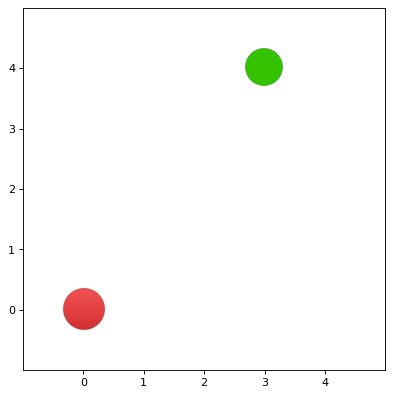

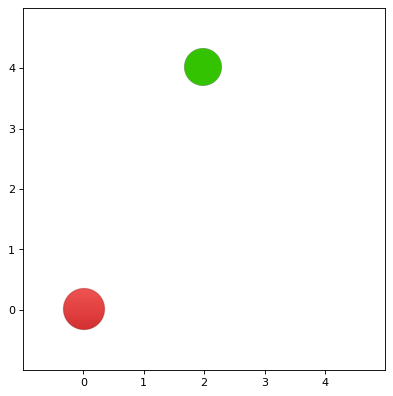

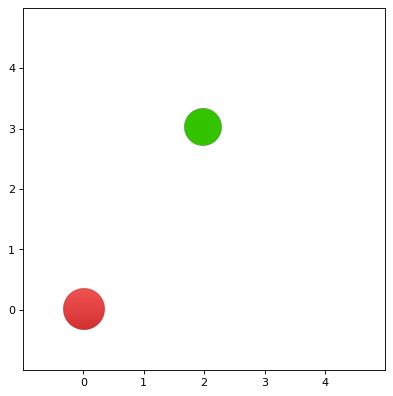

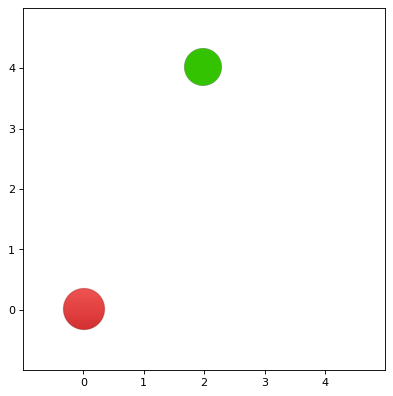

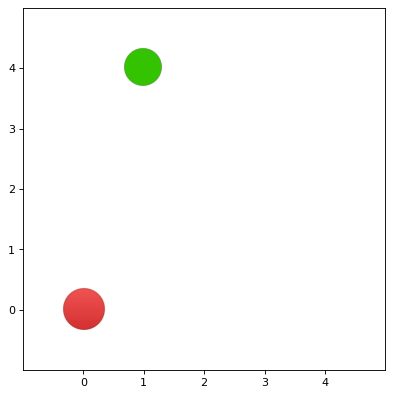

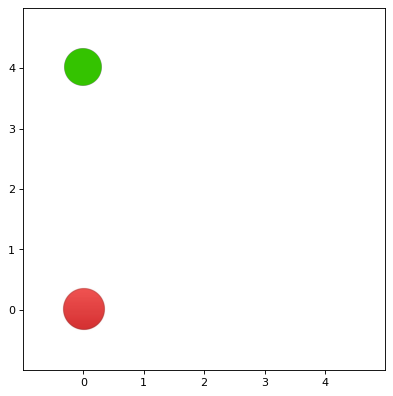

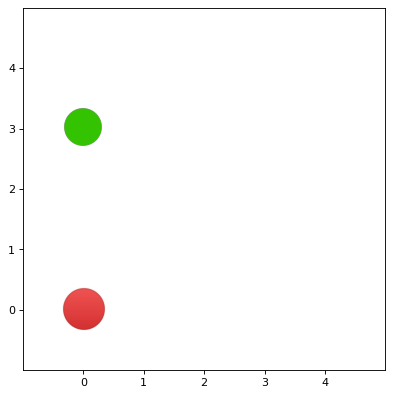

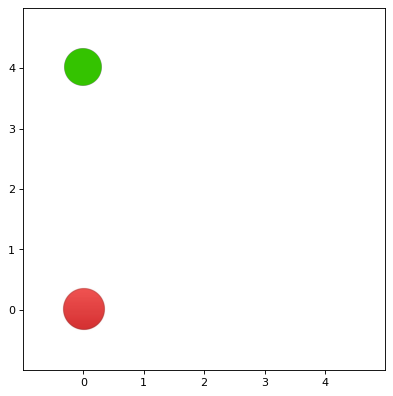

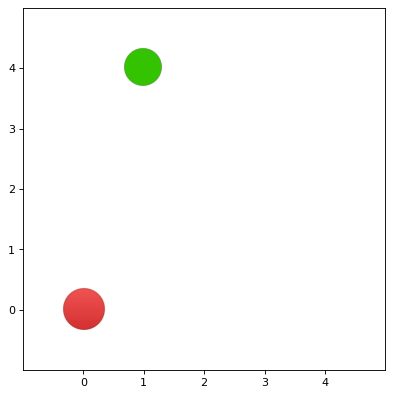

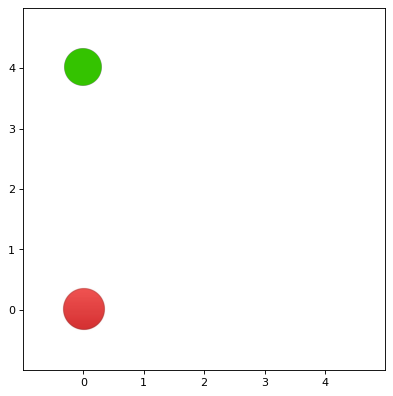

In [31]:
"""
This runs the environment using random actions
"""

print('Setting up environment')
env = Environment(5)
num_episodes = 1 # number of games we want the agent to play
env.reset()
frames = []
RENDER = True
print('Running random simulation')
for episode in range(num_episodes):
  print('Resetting environment')
  s = env.reset() # Initial state
  while True: 
    a = np.random.choice(range(4)) # choose a random action
    s_, r, done = env.step(a) # apply random action
    
    if RENDER:
      fig = env.render()
      plt.imshow(fig)
      plt.show()
      frames.append(fig)

    if done:
      break

In [32]:
%%time

learning = 0.1
discount = 0.95
epsilon = 0.5
min_eps = 0.0
episodes = 5000
epsilon_decay = (epsilon-min_eps)/episodes
reward_list = []
ave_reward_list = []
win_count = 0
cumu_timesteps = 0

discrete_obs_size = [5]*4
q_table = np.random.uniform(low=-2, high=0, size=(discrete_obs_size+[4]))
print(q_table.shape)

def get_discrete_state(state):
  discrete_state = (state-env.observation_space.low)/discrete_obs_window
  return tuple(discrete_state.astype(np.int))

for episode in range(episodes):
  state = tuple(env.reset().astype(np.int))
  tot_reward = 0
  done=False
  while not done:

    cumu_timesteps+=1
    if np.random.random() > epsilon:
      action = np.argmax(q_table[state])
    else:
      action = np.random.randint(0, 4)
      
    new_state, reward, done = env.step(action)
    new_state = tuple(new_state.astype(np.int))
    if not done:
      max_future_q = np.max(q_table[new_state])
      current_q = q_table[state + (action,)]
      new_q = (1-learning)*current_q + learning*(reward + discount*max_future_q)
      q_table[state + (action,)] = new_q
    
    elif done:
      win_count+=1
    
    tot_reward+=reward
    state = new_state
  
  if epsilon > min_eps:
    epsilon-=epsilon_decay
  reward_list.append(tot_reward)
        
  if (episode+1) % 100 == 0:
      ave_reward = np.mean(reward_list[episode-99:])
      ave_reward_list.append(ave_reward)
      
  if (episode+1) % 500 == 0:    
      print('Episode {} Average Reward: {}'.format(episode+1, ave_reward))
print(win_count)

(5, 5, 5, 5, 4)
Episode 500 Average Reward: 4.31
Episode 1000 Average Reward: 4.97
Episode 1500 Average Reward: 5.38
Episode 2000 Average Reward: 6.14
Episode 2500 Average Reward: 6.55
Episode 3000 Average Reward: 6.84
Episode 3500 Average Reward: 7.3
Episode 4000 Average Reward: 7.61
Episode 4500 Average Reward: 7.84
Episode 5000 Average Reward: 7.99
5000
CPU times: user 1.81 s, sys: 134 ms, total: 1.94 s
Wall time: 1.81 s


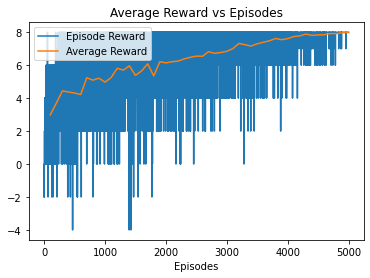

In [33]:
plt.plot(np.arange(len(reward_list)), reward_list, label='Episode Reward')
plt.plot(100*(np.arange(len(ave_reward_list)) + 1), ave_reward_list, label='Average Reward')
plt.legend(loc='upper left')
plt.xlabel('Episodes')
plt.title('Average Reward vs Episodes')   
plt.show()

In [34]:
#-------------------- BRAIN ---------------------------

class Brain:
  """The 'brain' of the agent, where the model is created and held.
  
  state_dim (int): the size of the observation space
  action_dim (int): the size of the action space
  
  """
  def __init__(self, state_dim, action_dim, weights=None):
    self.state_dim = state_dim
    self.action_dim = action_dim

    self.model = self._createModel()
    if weights:
      self.model.load_weights("brain.h5")

  def _createModel(self):
    # Creates a Sequential Keras model
    # This acts as the Deep Q-Network (DQN)
    
    model = Sequential()

    ### START CODE HERE ### (≈ 3 lines of code)
    # 'Dense' is the basic form of a neural network layer
    # Input Layer with activation function relu and Hidden Layer with 128 nodes
    model.add(Dense(128, input_dim=self.state_dim, activation='relu'))
    #Second Hidden layer with 128 nodes
    model.add(Dense(128, activation='relu'))
    #Output layer with activation linear.
    #action_size=4
    model.add(Dense(self.action_dim, activation='linear'))
    
    
    ### END CODE HERE ###

    opt = RMSprop(lr=0.00025)
    model.compile(loss='mse', optimizer=opt)

    return model

  def train(self, x, y, epoch=1, verbose=0):
    self.model.fit(x, y, batch_size=64, epochs=epoch, verbose=verbose)

  def predict(self, s):
    return self.model.predict(s)

  def predictOne(self, s):
    return self.predict(s.reshape(1, self.state_dim)).flatten()

In [35]:
#-------------------- MEMORY --------------------------
class Memory:   # stored as ( s, a, r, s_ )
  """The agent's 'memory', where experiences are stored
  """

  def __init__(self, capacity):
    self.capacity = capacity
    self.samples = []

  def add(self, sample):
    # a sample should be an array [s, a, r, s_]
    # s: current state
    # a: current action
    # r: current reward
    # s_: next state
    self.samples.append(sample)        

    if len(self.samples) > self.capacity:
        self.samples.pop(0)

  def sample(self, n):
    n = min(n, len(self.samples))
    return random.sample(self.samples, n)

In [36]:
#-------------------- AGENT ---------------------------
import math 
class Agent:
  """The agent, which learns to navigate the environment
  
  """
  
  def __init__(self, state_dim, action_dim, memory_capacity = 10000,
              batch_size = 64, gamma = 0.99, lamb = 0.001,
               max_epsilon = 1., min_epsilon = 0.01):
    self.state_dim = state_dim
    self.action_dim = action_dim

    self.batch_size = batch_size
    self.gamma = gamma # discount rate, to calculate the future discounted reward
    self.lamb = lamb
    self.max_epsilon = max_epsilon
    self.epsilon = max_epsilon
    self.min_epsilon = min_epsilon
    
    self.brain = Brain(state_dim, action_dim)
    self.memory = Memory(memory_capacity)
    self.steps = 0
    self.epsilons = []

  def act(self, s, verbose=False):
    """The policy of the agent:
    Here, we determine if we explore (take a random action) based on epsilon.
    If not, we have the model predict the Q-Values for the state,
    then take the action which maximizes those values.
    """
    if random.random() < self.epsilon:
      if verbose:
        print("Random Action.")
      return random.randint(0, self.action_dim-1)
    else:
      actions = self.brain.predictOne(s)
      if verbose:
        print("Actions:", actions)
      return np.argmax(actions)



  def observe(self, sample):  # in (s, a, r, s_) format
    """The agent observes an event.
    We pass a sample (state, action, reward, next state) to be stored in memory.
    We then increment the step count and adjust epsilon accordingly.
    """
    self.memory.add(sample)        

    # slowly decrease Epsilon based on our eperience
    self.steps += 1
    
    ### START CODE HERE ### (≈ 1 line of code)
    
    self.epsilon=self.min_epsilon+(self.max_epsilon-self.min_epsilon)* math.exp((-self.lamb)*abs(self.steps))
    #ϵ=ϵmin+(ϵmax−ϵmin)∗e−λ|S|
   
    ### END CODE HERE ###
    
    self.epsilons.append(self.epsilon)

  def replay(self):
    """The agent learns based on previous experiences.
    We sample observations (state, action, reward, next state) from memory.
    We train the model based on these observations.
    """
    
    # Random sample of experiences
    batch = self.memory.sample(self.batch_size)
    batch_size = len(batch)

    
    # Extracting states ('current' and 'next') from samples
    no_state = np.zeros(self.state_dim)
    states = np.array([ o[0] for o in batch ])
    states_next = np.array([ (no_state if o[3] is None else o[3]) for o in batch ])
    

    # Estimating Q-Values for states
    q_vals = self.brain.predict(states)
    q_vals_next = self.brain.predict(states_next)

    
    # Setting up training data
    x = np.zeros((batch_size, self.state_dim))
    y = np.zeros((batch_size, self.action_dim))
    done=False
    for i in range(batch_size):
        obs = batch[i]
        st = obs[0]; 
        act = obs[1]; 
        rew = obs[2]; 
        st_next = obs[3]
        t = q_vals[i]

      ### START CODE HERE ### (≈ 4 line of code)
        if st_next is None:
            t[act]=rew
        else:
            t[act] = (rew + self.gamma *np.amax(q_vals_next[i]))
    
    
    
      ### END CODE HERE ###

      # Set training data
        x[i] = st
        y[i] = t


    # Train
    self.brain.train(x, y)

Setting up environment
Setting up agent
Running simulation


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Episode 0
Time Elapsed: 2.25s
Epsilon 0.9995251187302109
Last Episode Reward: -2
Episode Reward Rolling Mean: nan
----------


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Episode 100
Time Elapsed: 10.25s
Epsilon 0.9532162322387105
Last Episode Reward: 2
Episode Reward Rolling Mean: -2.0
----------
Episode 200
Time Elapsed: 18.24s
Epsilon 0.9091658567921319
Last Episode Reward: 0
Episode Reward Rolling Mean: 0.039603960396039604
----------
Episode 300
Time Elapsed: 26.33s
Epsilon 0.8673455739778486
Last Episode Reward: 0
Episode Reward Rolling Mean: 0.4079601990049751
----------
Episode 400
Time Elapsed: 34.91s
Epsilon 0.8275997911742705
Last Episode Reward: 4
Episode Reward Rolling Mean: 0.6245847176079734
----------
Episode 500
Time Elapsed: 43.36s
Epsilon 0.7898977378798718
Last Episode Reward: 2
Episode Reward Rolling Mean: 0.7805486284289277
----------
Episode 600
Time Elapsed: 51.50s
Epsilon 0.7540588768811834
Last Episode Reward: 2
Episode Reward Rolling Mean: 0.9760479041916168
----------
Episode 700
Time Elapsed: 59.58s
Epsilon 0.7198219860330917
Last Episode Reward: -2
Episode Reward Rolling Mean: 1.0615640599001663
----------
Episode 800
Time 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Episode 1000
Time Elapsed: 85.67s
Epsilon 0.62712679126456
Last Episode Reward: 2
Episode Reward Rolling Mean: 1.6204217536071033
----------
Episode 1100
Time Elapsed: 95.09s
Epsilon 0.599117247671965
Last Episode Reward: 4
Episode Reward Rolling Mean: 1.7482517482517483
----------
Episode 1200
Time Elapsed: 103.89s
Epsilon 0.5728852248328712
Last Episode Reward: 2
Episode Reward Rolling Mean: 1.9409627611262488
----------
Episode 1300
Time Elapsed: 112.48s
Epsilon 0.5476823313315917
Last Episode Reward: 6
Episode Reward Rolling Mean: 2.1432139883430477
----------
Episode 1400
Time Elapsed: 120.98s
Epsilon 0.5236705247758162
Last Episode Reward: 8
Episode Reward Rolling Mean: 2.2659492697924675
----------
Episode 1500
Time Elapsed: 129.68s
Epsilon 0.5011780200615118
Last Episode Reward: 4
Episode Reward Rolling Mean: 2.404710920770878
----------
Episode 1600
Time Elapsed: 138.68s
Epsilon 0.47968912606930925
Last Episode Reward: 2
Episode Reward Rolling Mean: 2.5636242504996667
--------

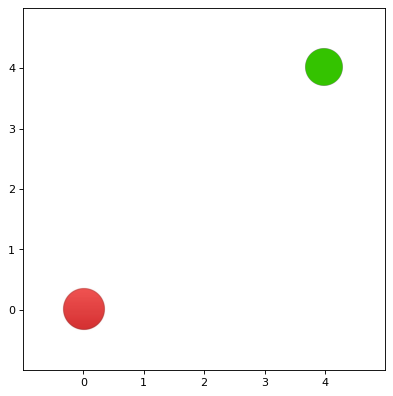

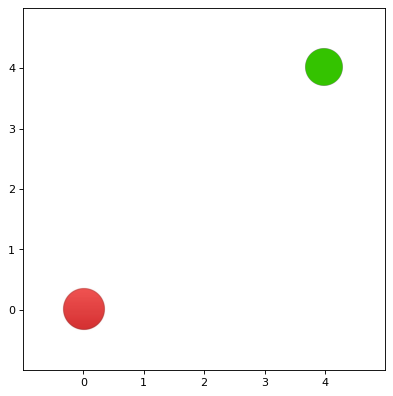

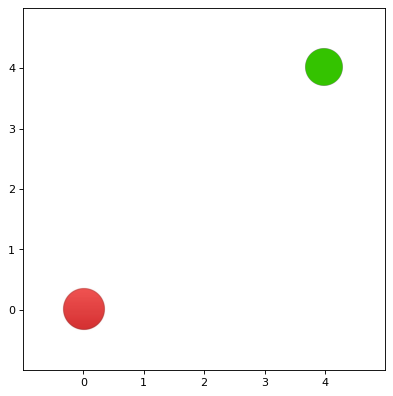

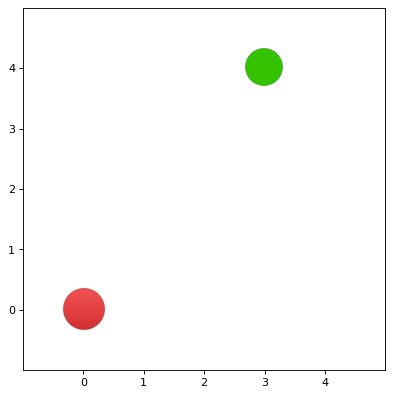

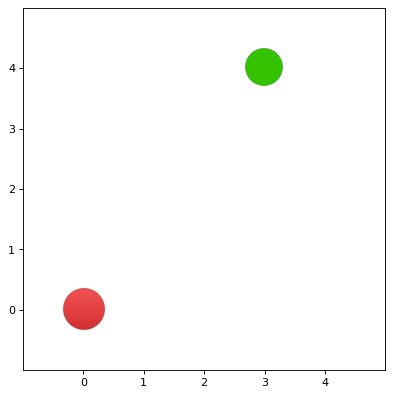

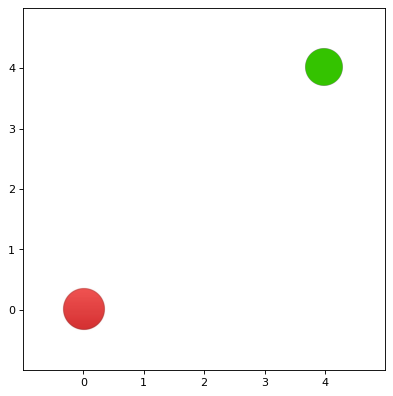

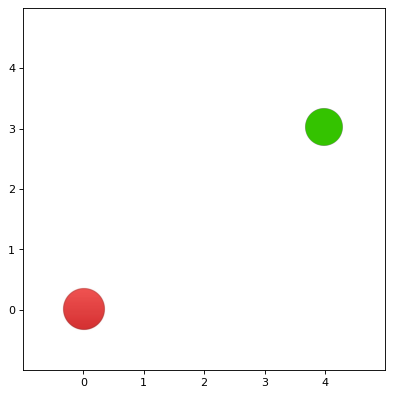

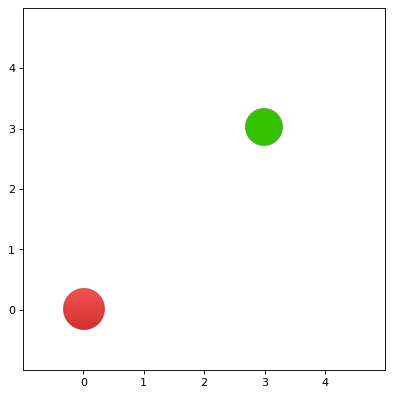

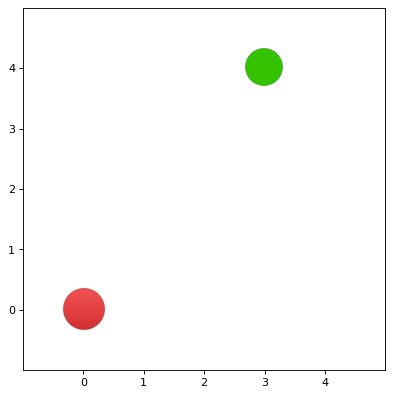

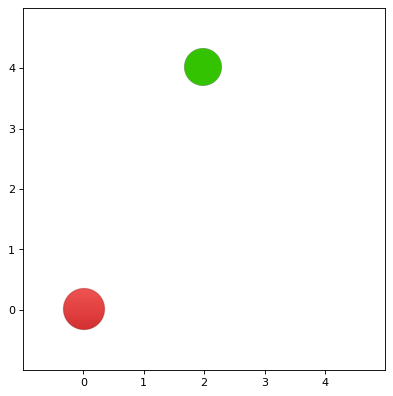

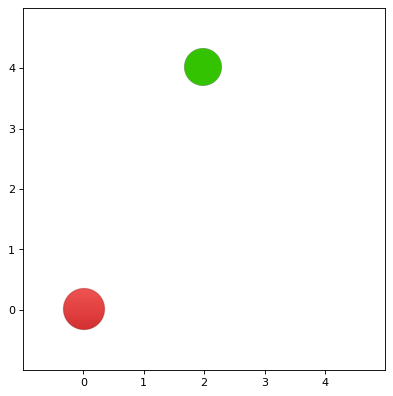

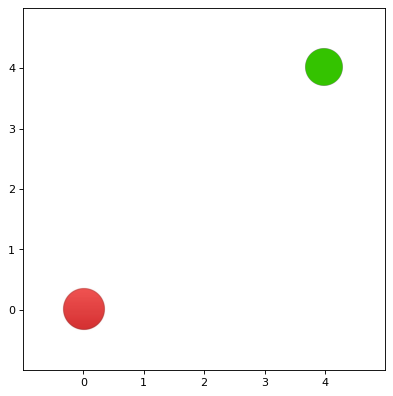

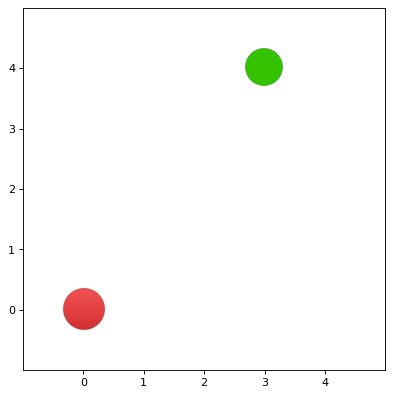

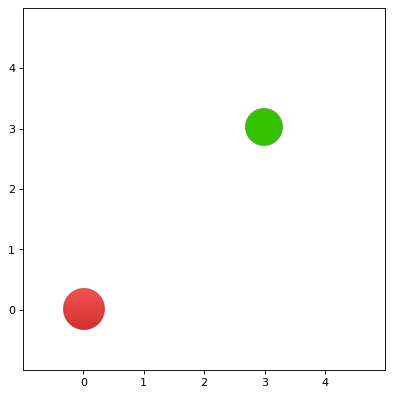

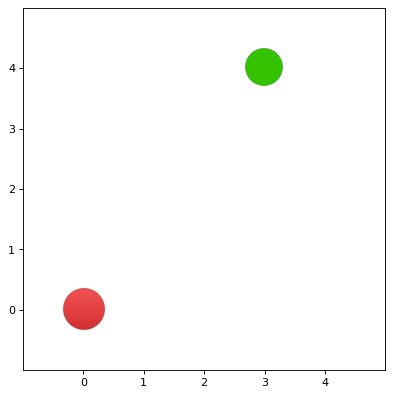

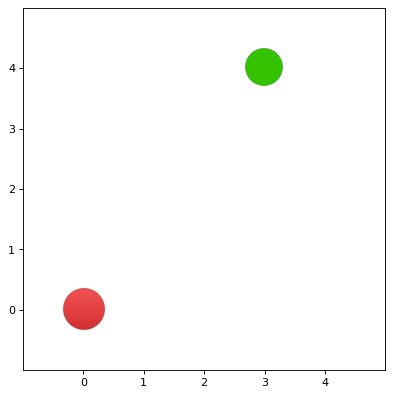

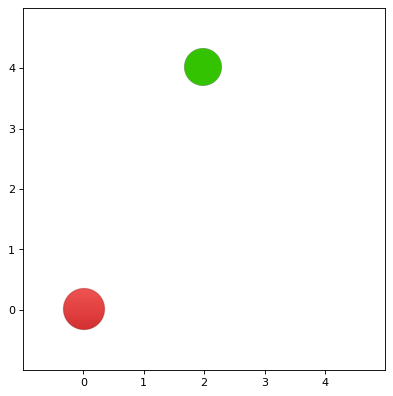

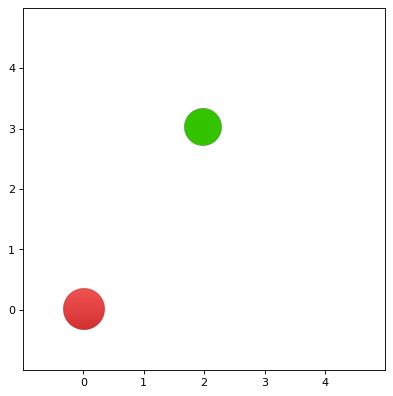

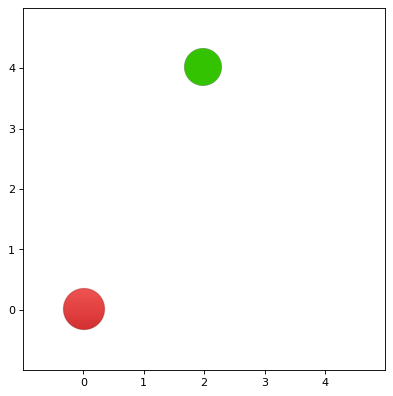

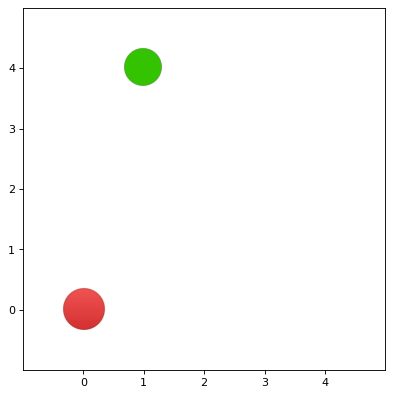

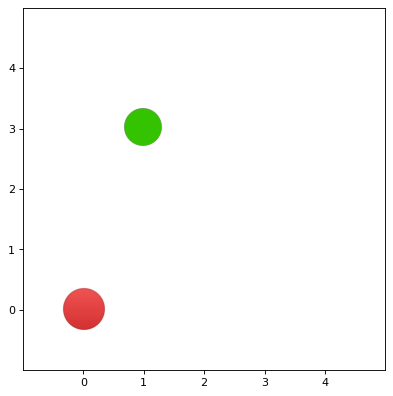

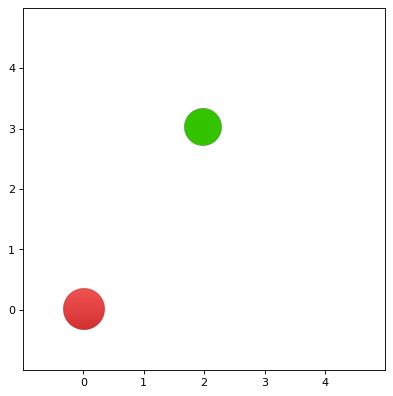

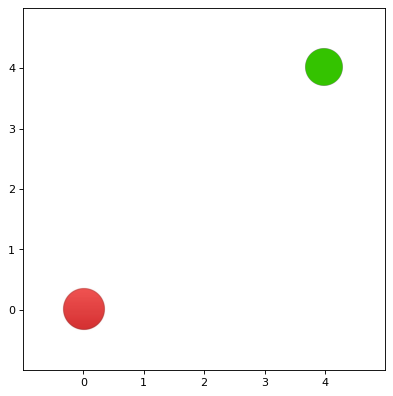

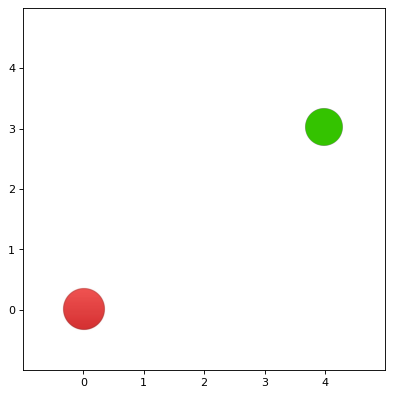

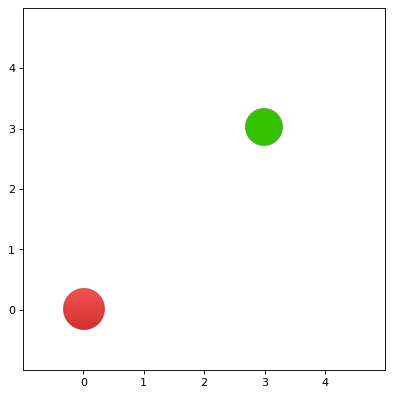

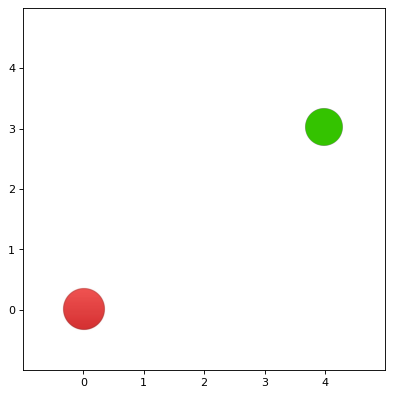

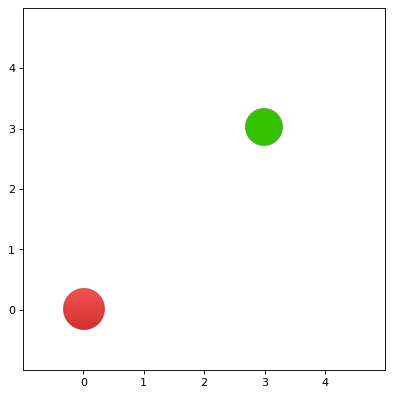

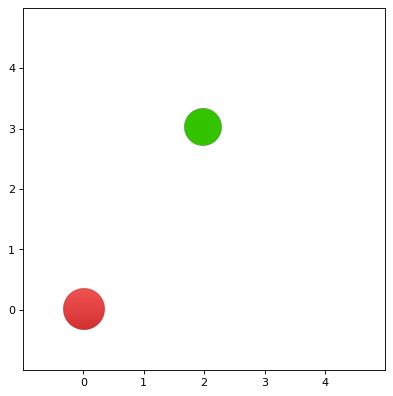

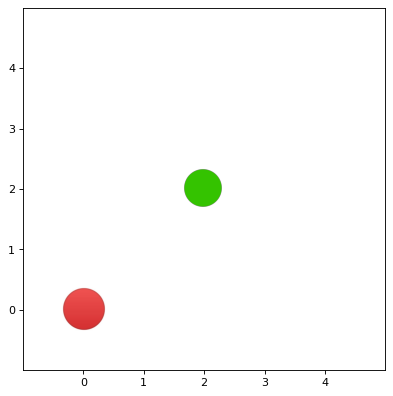

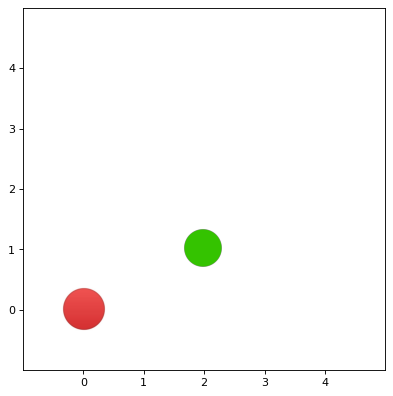

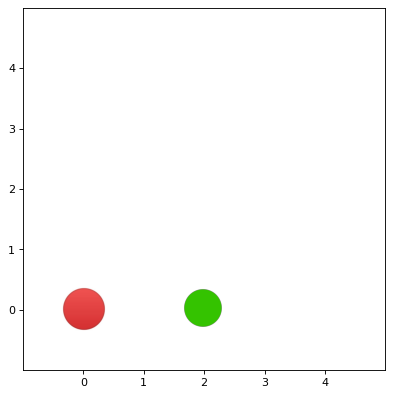

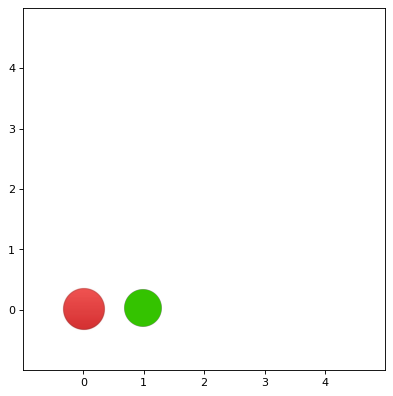

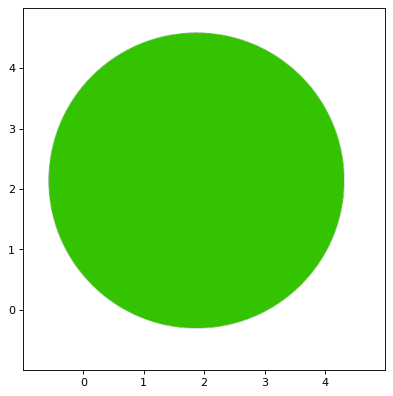

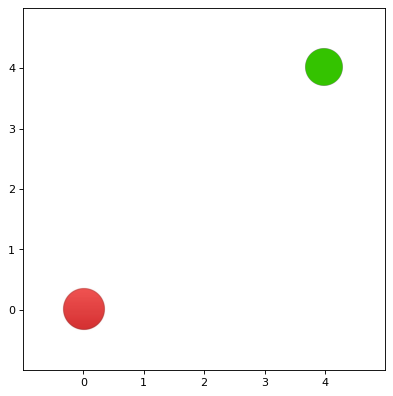

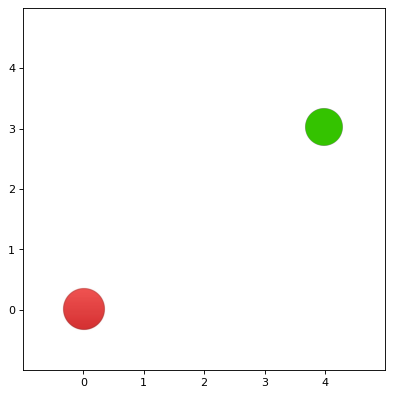

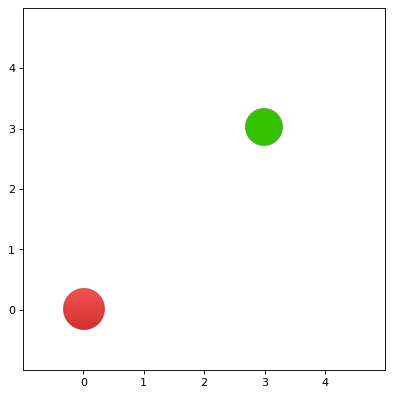

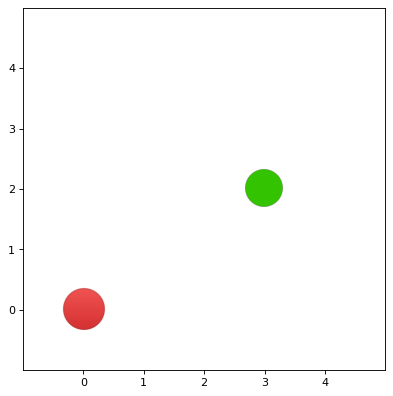

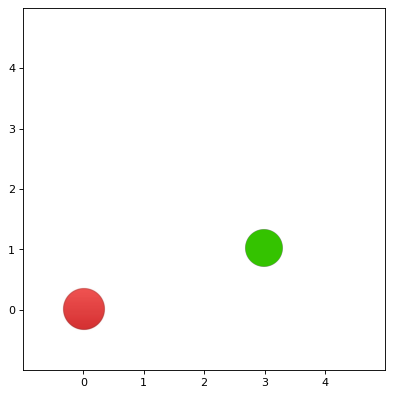

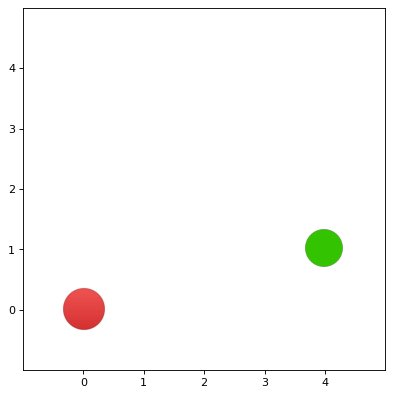

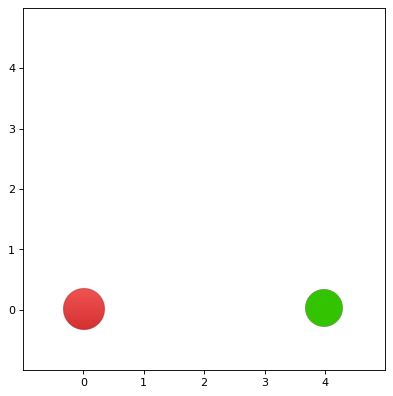

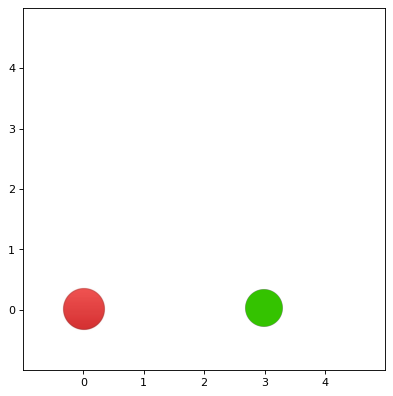

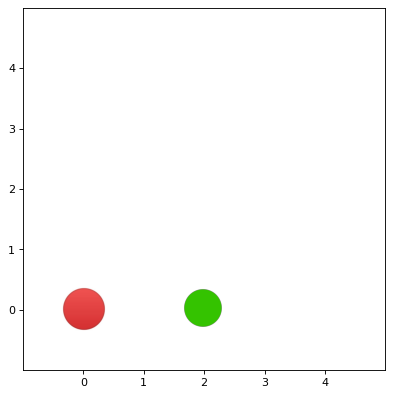

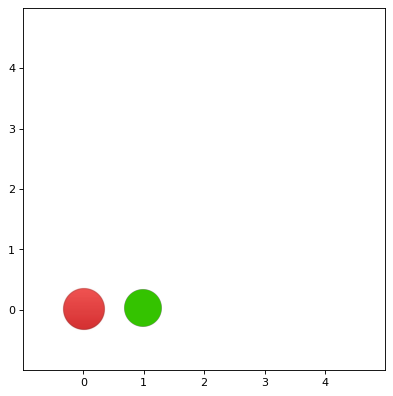

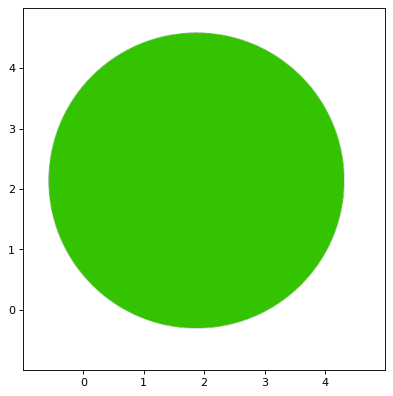

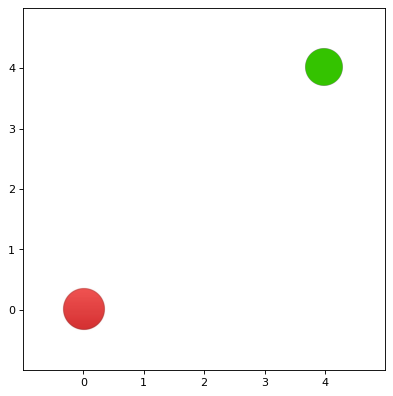

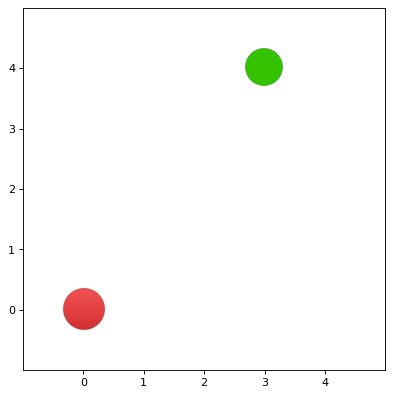

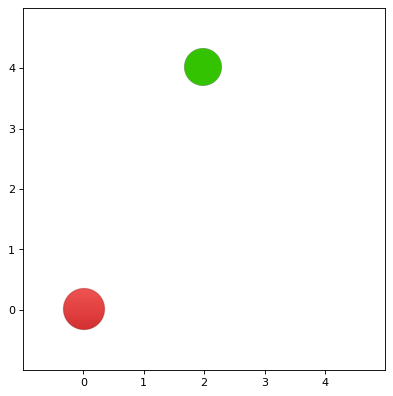

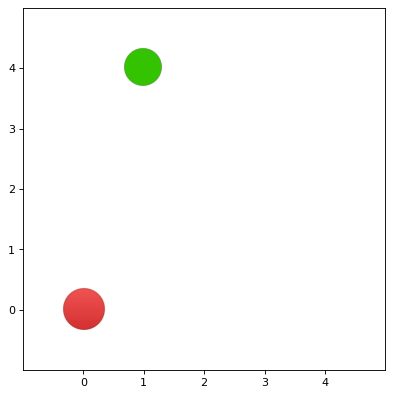

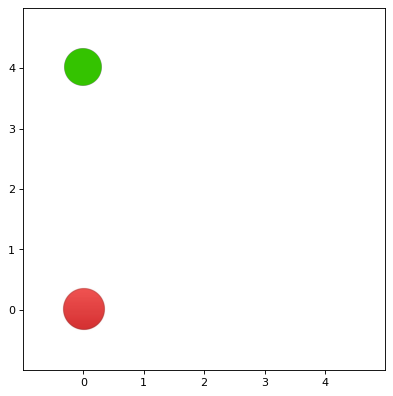

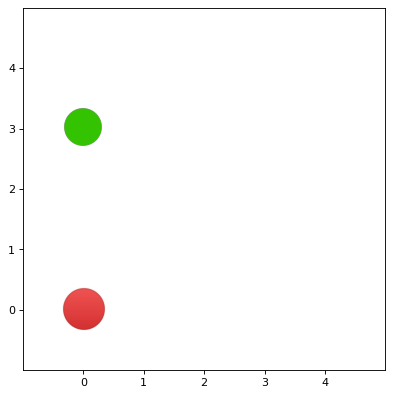

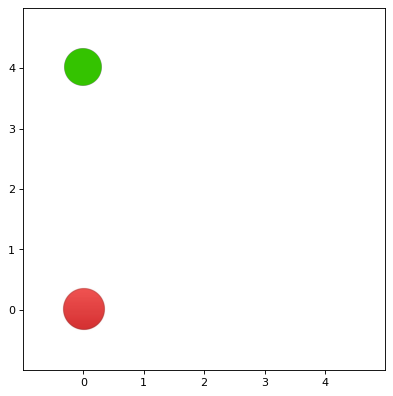

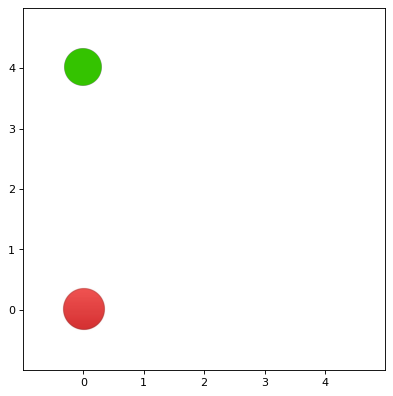

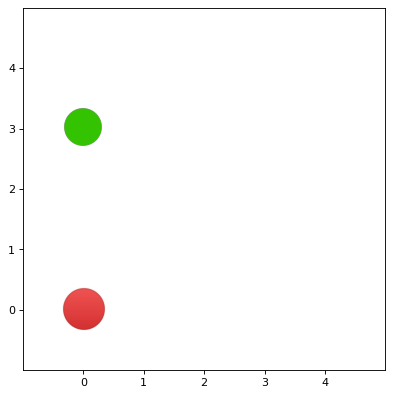

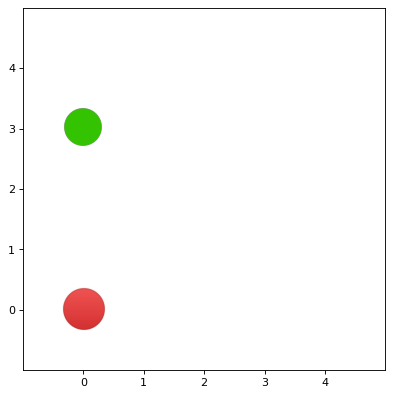

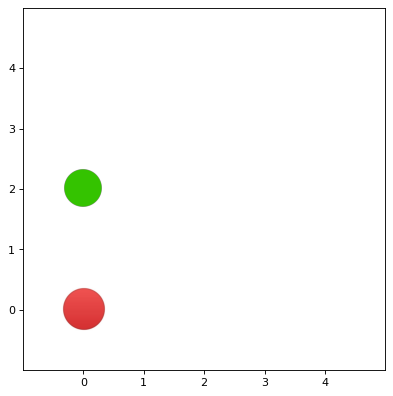

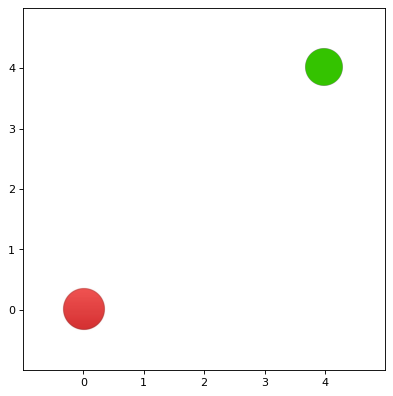

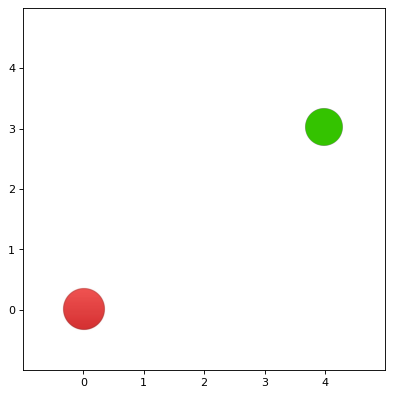

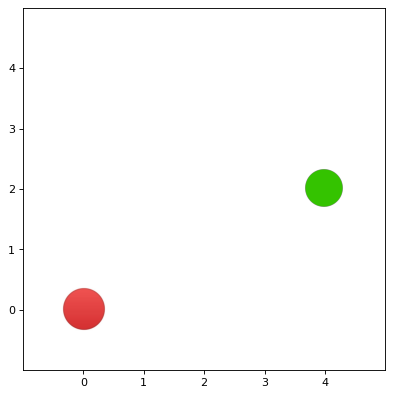

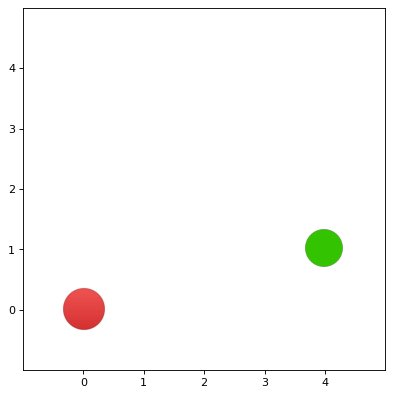

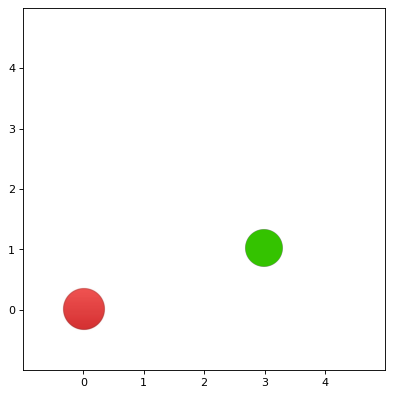

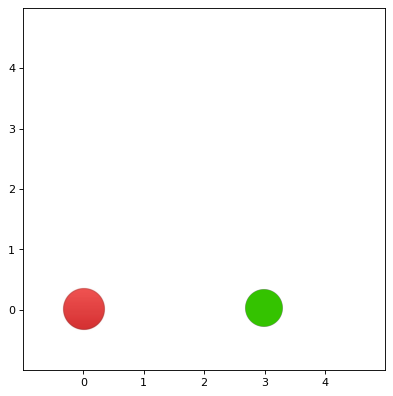

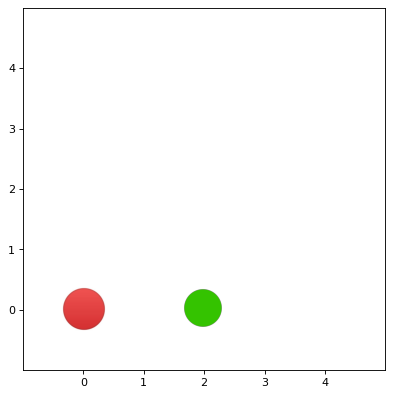

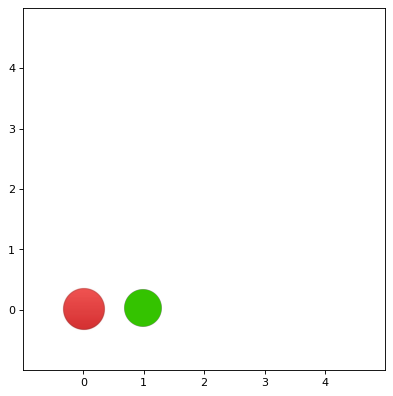

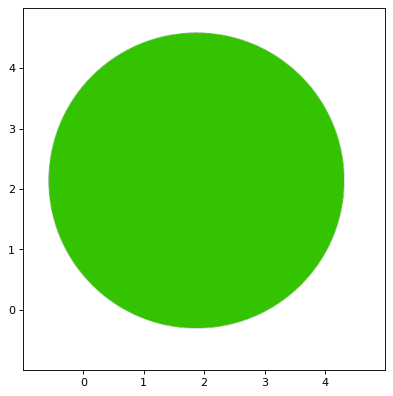

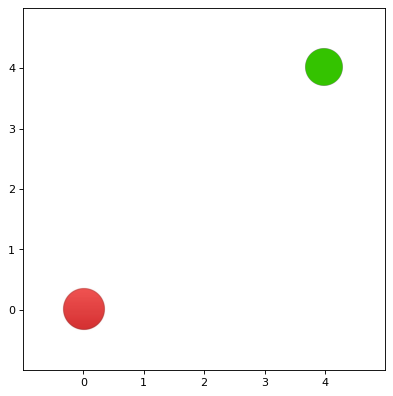

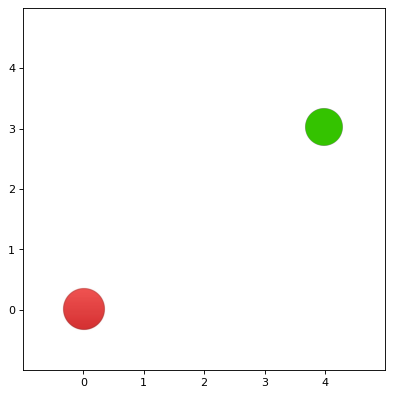

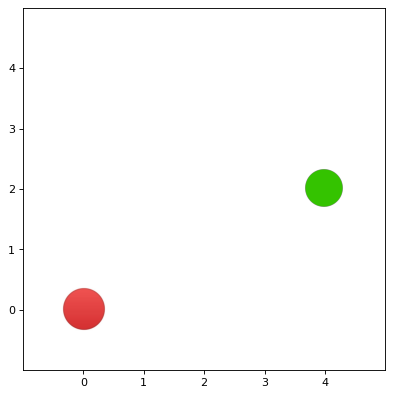

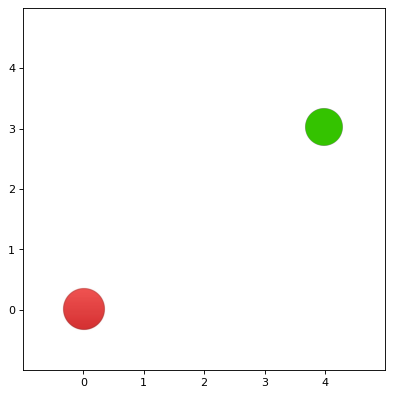

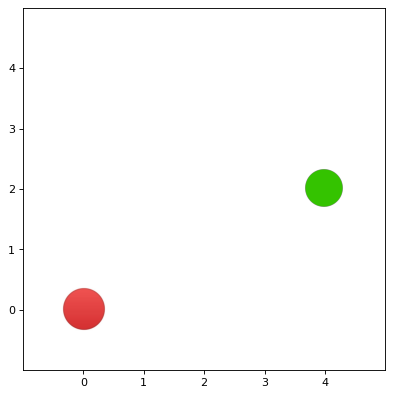

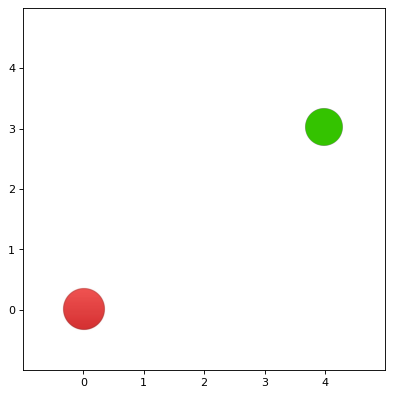

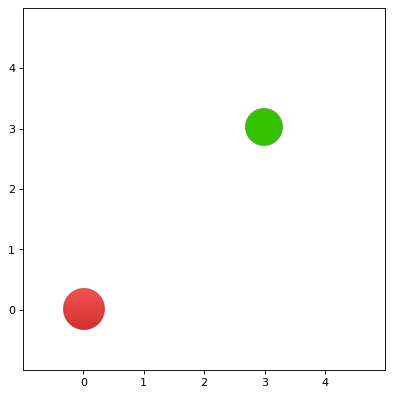

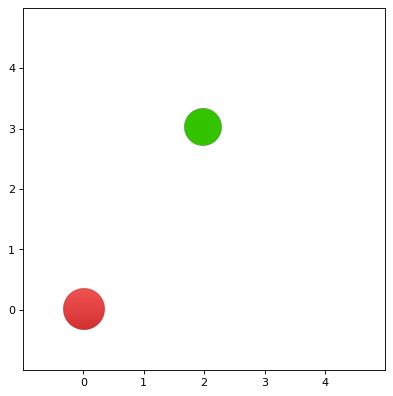

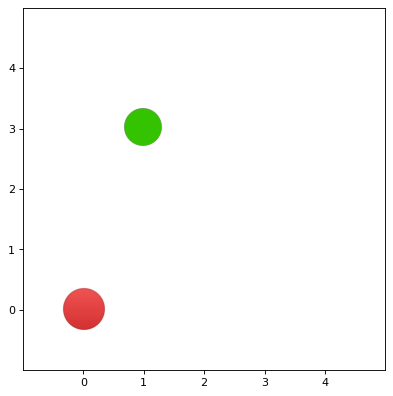

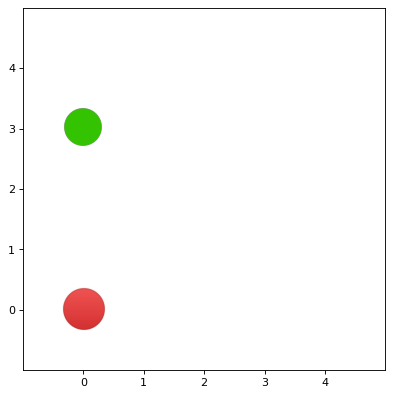

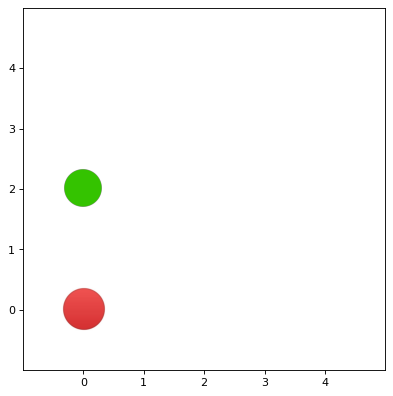

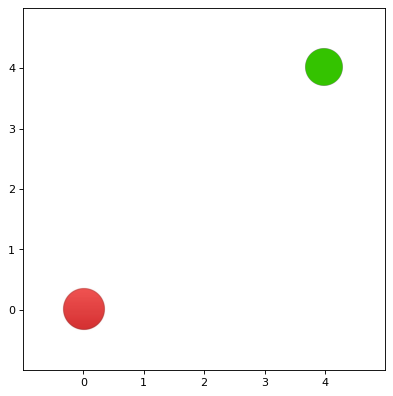

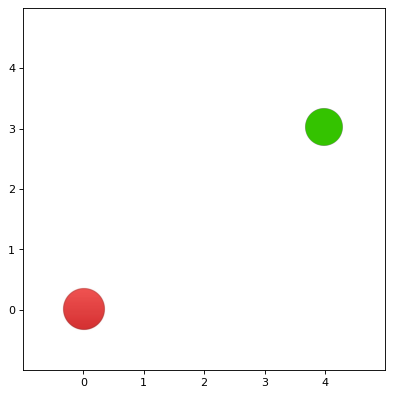

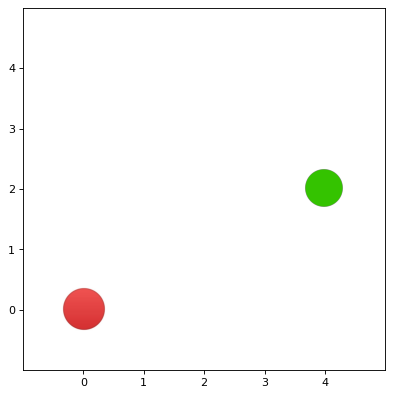

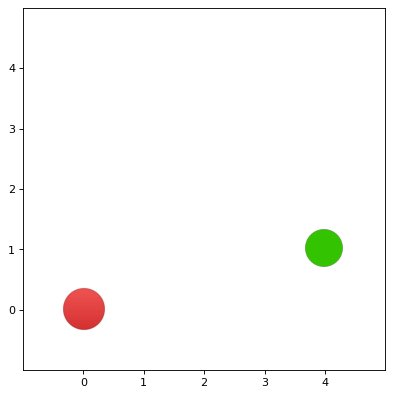

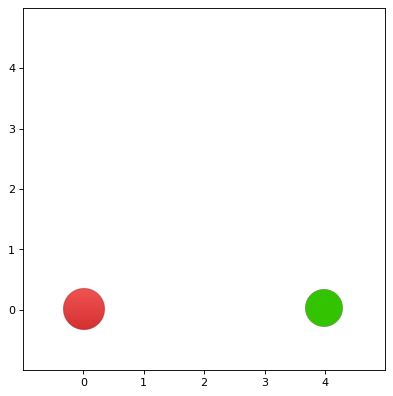

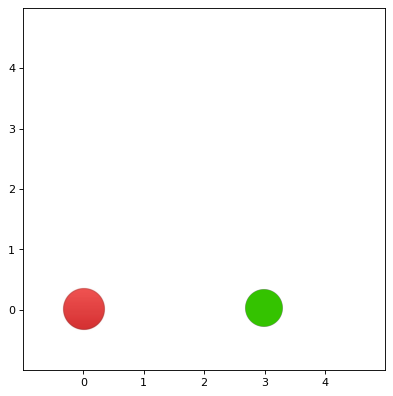

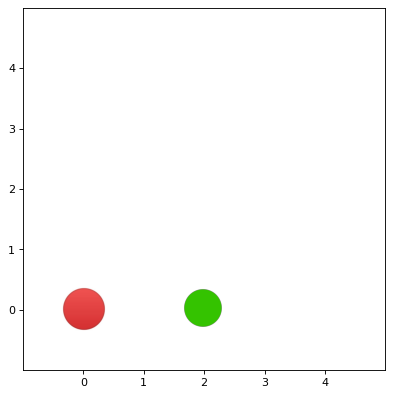

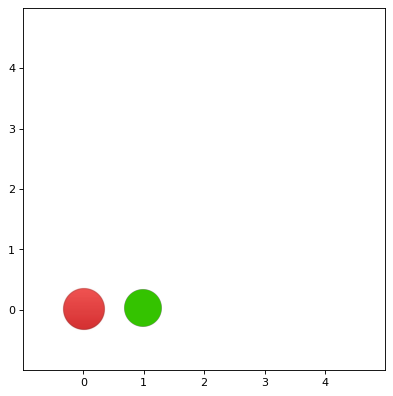

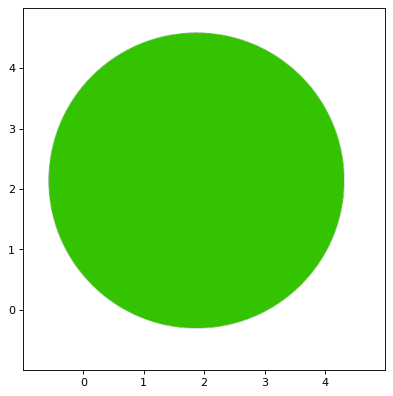

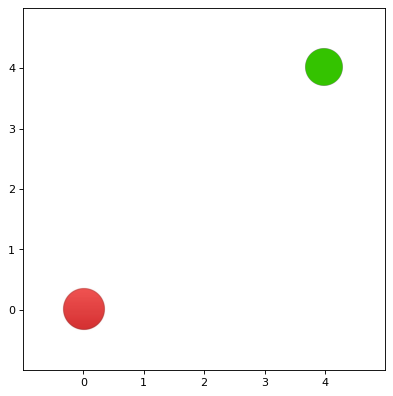

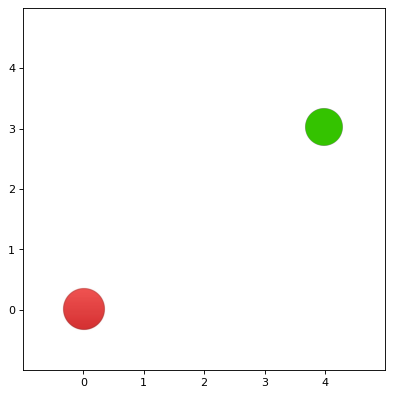

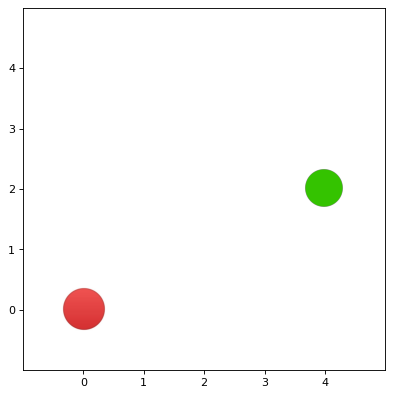

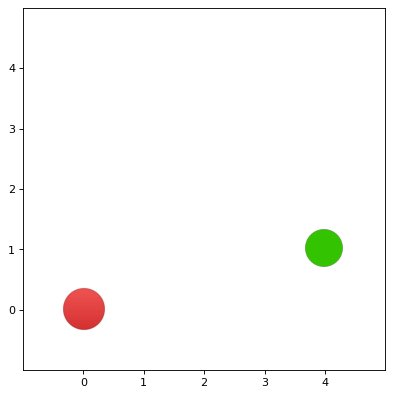

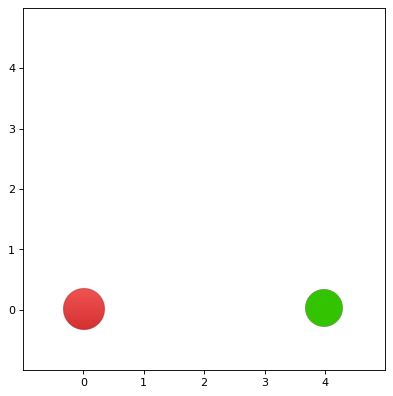

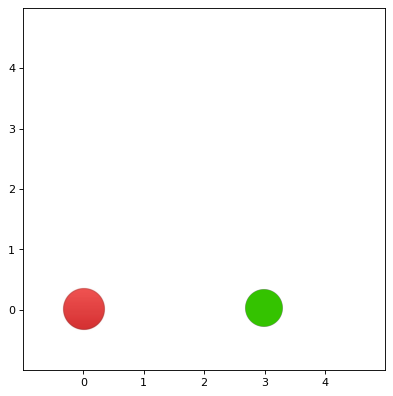

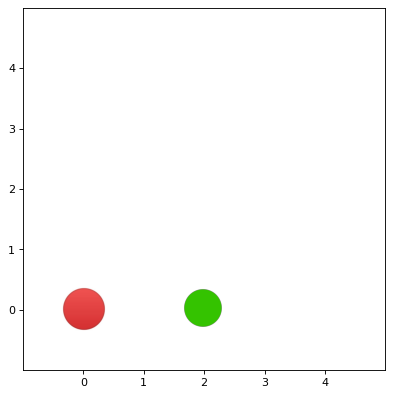

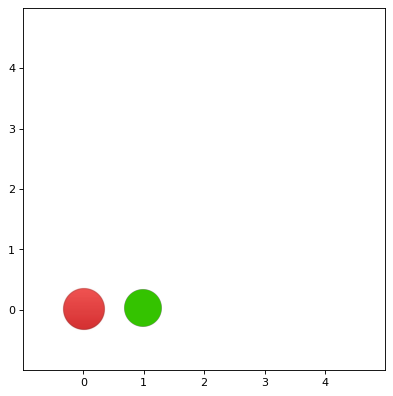

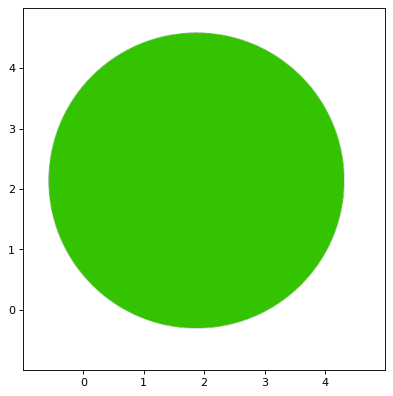

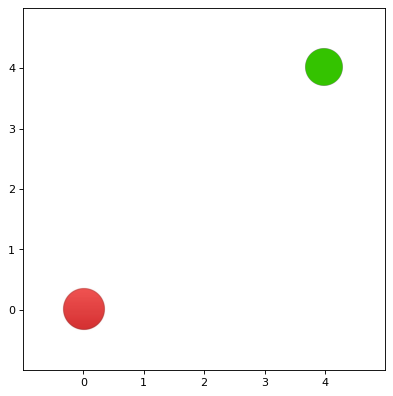

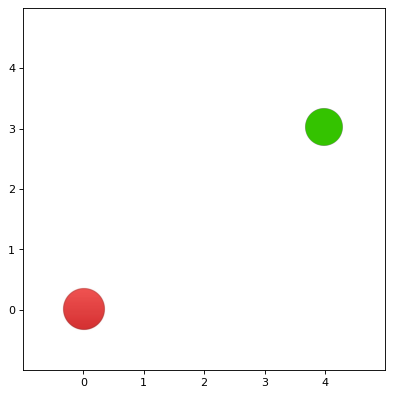

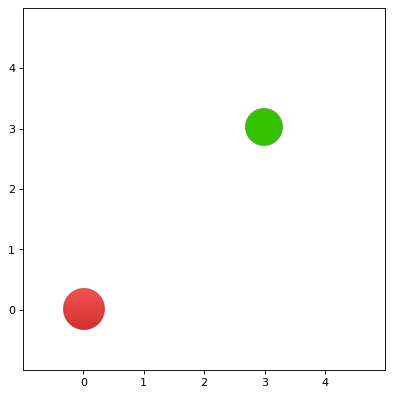

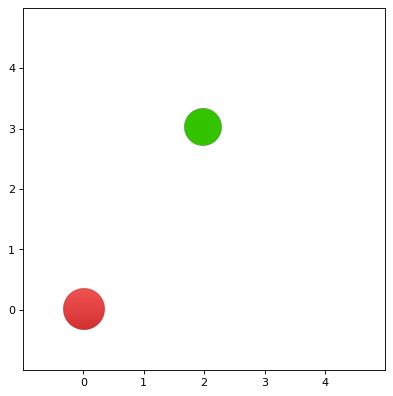

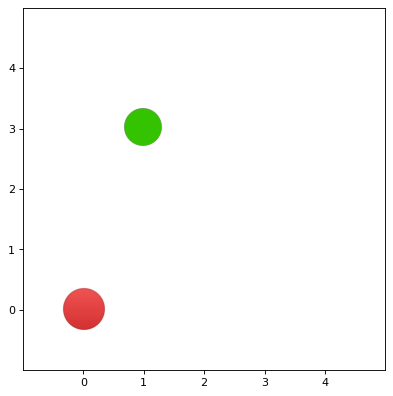

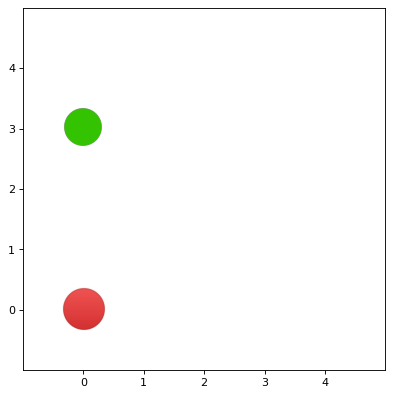

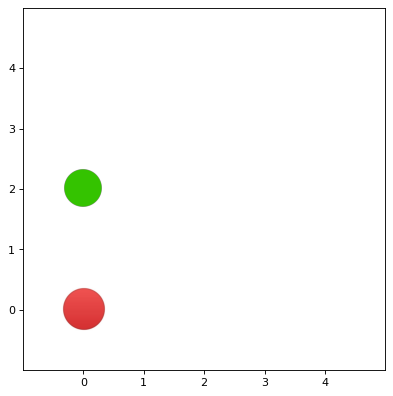

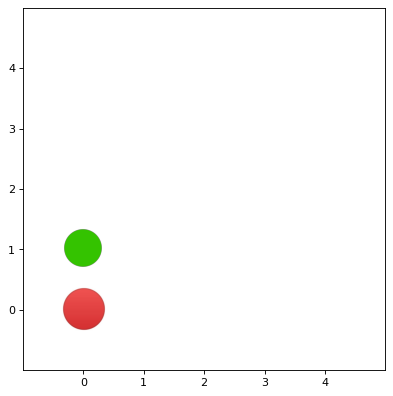

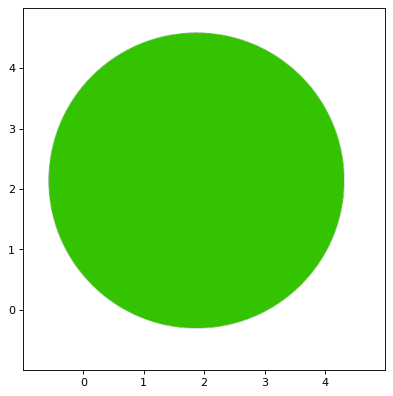

In [37]:
#-------------------- MAIN ----------------------------
print('Setting up environment')
env = Environment(5)

state_dim = 4
action_dim = 4 # left, right, up, down
print('Setting up agent')
MAX_EPSILON = 1 # the rate in which an agent randomly decides its action
MIN_EPSILON = 0.05 # min rate in which an agent randomly decides its action
LAMBDA = 0.00005      # speed of decay for epsilon
num_episodes = 10000 # number of games we want the agent to play

VERBOSE = False
agent = Agent(state_dim, action_dim, lamb=LAMBDA,
              max_epsilon=MAX_EPSILON, min_epsilon=MIN_EPSILON)
env.reset()
episode_rewards = []
epsilons = []
t0 = time.time()
frames = []

print('Running simulation')
for episode in range(num_episodes):
  s = env.reset() # Initial state
  if episode % 1000 == 0:
      fig = env.render()
      frames.append(fig)
  R = 0
  while True: 
    a = agent.act(s, verbose=VERBOSE)

    s_, r, done = env.step(a)

    if done: # terminal state
        s_ = None

    agent.observe( (s, a, r, s_) )
    agent.replay()

    s = s_
    R += r
    
    if episode % 1000 == 0:
      fig = env.render()
      frames.append(fig)
    
    if VERBOSE:
      print("Action:", a)
      print("Reward:", r)

    if done:
      break
      
  epsilons.append(agent.epsilon)
  episode_rewards.append(R)
  
  if episode % 100 == 0:
    print('Episode {}'.format(episode))
    print('Time Elapsed: {0:.2f}s'.format(time.time() - t0))
    print('Epsilon {}'.format(epsilons[-1]))
    print('Last Episode Reward: {}'.format(R))
    print('Episode Reward Rolling Mean: {}'.format(np.mean(episode_rewards[:-100])))
    print('-'*10)
    

agent.brain.model.save("brain.h5")